## Training a feedforward neural network for language modeling

This project explores the use of Feedforward Neural Networks (FNNs) in language modeling. The primary objective is to build a neural network that learns word relationships and generates meaningful text sequences. The implementation is done using PyTorch, covering key aspects of Natural Language Processing (NLP), such as:
* Tokenization & Indexing: Converting text into numerical representations.
* Embedding Layers: Mapping words to dense vector representations for efficient learning.
* Context-Target Pair Generation (N-grams): Structuring training data for sequence prediction.
* Multi-Class Neural Network: Designing a model to predict the next word in a sequence.



The training process includes optimizing the model with loss functions and backpropagation techniques to improve accuracy and coherence in text generation. By the end of the project, you will have a working FNN-based language model capable of generating text sequences.

In [76]:
%%capture
import warnings
from tqdm import tqdm

warnings.simplefilter('ignore')
import time
from collections import OrderedDict

import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import string
import time
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
%capture

## Feedforward Neural Networks (FNNs) for language models

FNNs, or Multi-Layer Perceptrons, serve as the foundational components for comprehending neural networks in natural language processing (NLP). **In NLP tasks, FNNs process textual data by transforming it into numerical vectors known as embeddings** Subsequently, these embeddings are input to the network to predict language facets, such as the upcoming word in a sentence or the sentiment of a text.

Let's consider the following song lyrics for our analysis.

In [77]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

### Tokenization

In [78]:
tokenizer = get_tokenizer("basic_english")
tokens=tokenizer(song)

In [79]:
def preprocess_string(s):
    """
    Preprocesses a given string by performing the following steps:
    
    1. Removes all non-word characters (excluding letters and numbers).
    2. Removes all whitespace characters.
    3. Removes all numeric digits.

    Parameters:
    s (str): The input string to be cleaned.

    Returns:
    str: The processed string with only alphabetic characters, no spaces, and no digits.
    """

    # Remove all non-word characters (everything except letters and numbers)
    # \w matches any word character (letters, numbers, and underscores)
    # \s matches any whitespace characters
    # ^ inside [] negates the selection, so [^\w\s] matches anything that's NOT a word character or whitespace.
    s = re.sub(r"[^\w\s]", '', s)

    # Remove all whitespace characters (spaces, tabs, newlines)
    # \s+ matches one or more whitespace characters.
    s = re.sub(r"\s+", '', s)

    # Remove all digits (0-9)
    # \d matches any digit character.
    s = re.sub(r"\d", '', s)

    return s

In [80]:
def preprocess(words):
    """
    Preprocesses a given text by tokenizing it, cleaning individual words, and 
    converting them to lowercase while removing empty or punctuation tokens.

    Steps:
    1. Tokenization: Splits the input text into individual word tokens.
    2. Cleaning: Applies `preprocess_string()` to remove non-word characters, 
       spaces, and digits from each token.
    3. Normalization: Converts all tokens to lowercase.
    4. Filtering: Removes empty strings and punctuation tokens.

    Parameters:
    words (str): The input text to be tokenized and preprocessed.

    Returns:
    list: A list of cleaned, lowercase tokens.
    """

    # Tokenize the input text into words
    tokens = word_tokenize(words)

    # Apply preprocessing to each token (removes unwanted characters)
    tokens = [preprocess_string(w) for w in tokens]

    # Convert tokens to lowercase and remove empty strings or punctuation
    return [w.lower() for w in tokens if len(w) != 0 and w not in string.punctuation]

# Example usage:
tokens = preprocess(song)  # Preprocess the text in 'song'

### Indexing

TorchText provides tools to tokenize text into individual words (tokens) and build a vocabulary, which maps tokens to unique integer indexes. This is a crucial step in preparing text data for  machine learning models that require numerical input.


In [81]:
def tokenizetext(song):
    """
    Tokenizes the input text (song) and builds a vocabulary from the tokens.

    Steps:
    1. Tokenization: The function splits the input text into words and applies 
       a tokenizer function to each word.
    2. Vocabulary Building: Constructs a vocabulary from the tokenized words,
       including a special "<unk>" token to handle out-of-vocabulary words.
    3. Default Indexing: Sets the default index for unknown words, ensuring 
       that any unseen tokens are mapped to "<unk>".

    Parameters:
    song (str): The input text (song lyrics) to be tokenized and processed.

    Returns:
    vocab (Vocab): A vocabulary object mapping tokens to their corresponding indices.
    """

    # Tokenize the text
    # Split the input text into words and apply the tokenizer function to each word.
    # The 'map' function ensures that each word is tokenized properly.
    tokenized_song = map(tokenizer, song.split())

    # Build vocabulary from tokenized text
    # The function `build_vocab_from_iterator` constructs a vocabulary by iterating 
    # over the tokenized words. The special token "<unk>" is added to handle words 
    # that are not present in the vocabulary.
    vocab = build_vocab_from_iterator(tokenized_song, specials=["<unk>"])

    # Set the default index for unknown words
    # The default index is set to the index of "<unk>" so that any word not found 
    # in the vocabulary is mapped to this token, preventing errors during lookup.
    vocab.set_default_index(vocab["<unk>"])

    return vocab


In [82]:
# Convert the tokens to indices by applying the function as shown here:


vocab = tokenizetext(song)

vocab(tokens[0:10])

[21, 58, 70, 74, 25, 69, 2, 20, 31, 72]

In [83]:
# Write a text function that converts raw text into indexes.

text_pipeline = lambda x: vocab(tokenizer(x))
text_pipeline(song)[0:10]

[21, 58, 70, 74, 25, 69, 2, 20, 31, 72]

Find the word corresponding to an index using the```get_itos()```method. The result is a list where the index of the list corresponds to a word.


In [84]:
index_to_token = vocab.get_itos()
index_to_token[67]

'guy'

## Embedding layers

An embedding layer is a crucial element in natural language processing (NLP) and neural networks designed for sequential data. It serves to convert categorical variables, like words or discrete indexes representing tokens, into continuous vectors. This transformation facilitates training and enables the network to learn meaningful relationships among words.

Let's consider a simple example involving a vocabulary of words 
- **Vocabulary**: {apple, banana, orange, pear}

Each word in your vocabulary has a unique index assigned to it: 
- **Indices**: {0, 1, 2, 3}

When using an embedding layer, you will initialize random continuous vectors for each index. For instance, the embedding vectors might look like:

- Vector for index 0 (apple): [0.2, 0.8]
- Vector for index 1 (banana): [0.6, -0.5]
- Vector for index 2 (orange): [-0.3, 0.7]
- Vector for index 3 (pear): [0.1, 0.4]
In PyTorch, you can create an embedding layer.


In [85]:
def genembedding(vocab):
    """
    Generates an embedding layer for the given vocabulary.

    The embedding layer transforms words into dense vector representations, 
    allowing the model to learn semantic relationships between words.

    Parameters:
    vocab (Vocab): The vocabulary object containing unique words and their indices.

    Returns:
    nn.Embedding: A PyTorch embedding layer with a specified embedding dimension.
    """

    # Define the embedding dimension (size of word vectors)
    embedding_dim = 20  # Each word will be represented as a 20-dimensional vector

    # Get the vocabulary size (number of unique words in the vocabulary)
    vocab_size = len(vocab)

    # Create an embedding layer
    # The nn.Embedding module maps word indices to dense vector representations.
    # It takes vocab_size as the number of words and embedding_dim as the vector size.
    embeddings = nn.Embedding(vocab_size, embedding_dim)

    return embeddings


**Embeddings**: Obtain the embedding for the first word with index 0 or 1. Don't forget that you have to convert the input into a tensor. The embeddings are initially initialized randomly, but as the model undergoes training, words with similar meanings gradually come to cluster closer together


In [86]:
embeddings=genembedding(vocab)
for n in range(2): 
    embedding=embeddings(torch.tensor(n))
    print("word",index_to_token[n])
    print("index",n)
    print( "embedding", embedding)
    print("embedding shape", embedding.shape)

word <unk>
index 0
embedding tensor([ 0.9619,  0.1377,  0.7240,  0.8900, -1.2920,  1.0299,  1.5087,  1.6399,
         1.4223,  0.3117,  0.6207, -1.0388,  0.3539, -0.1302,  1.2461, -0.1260,
         0.7993, -1.0726,  0.5038,  0.5536], grad_fn=<EmbeddingBackward0>)
embedding shape torch.Size([20])
word gonna
index 1
embedding tensor([ 1.0919,  1.2342, -0.2907, -0.2244,  0.7502, -0.8788, -0.3330,  1.6175,
         2.3502, -0.6828, -0.6826, -0.2363, -0.3351, -0.2942, -1.1811, -1.4090,
         0.1648,  1.0785, -1.0067, -1.2889], grad_fn=<EmbeddingBackward0>)
embedding shape torch.Size([20])


These vectors will serve as inputs for the next layer.


### Generating context-target pairs (n-grams)

Organize words within a variable-size context using the following approach: Each word is denoted by 'i'. 
To establish the context, simply subtract 'j'. The size of the context is determined by the value of``CONTEXT_SIZE``.


In [87]:
# Define the context size for generating n-grams
CONTEXT_SIZE = 2  # The number of previous words used to predict the next word

def genngrams(tokens, CONTEXT_SIZE=2):
    """
    Generates n-grams from a list of tokens, where each n-gram consists of a 
    context (previous words) and a target (next word).

    The function constructs a list of tuples where:
    - The first element is a list of `CONTEXT_SIZE` previous words.
    - The second element is the target word that follows the context.

    Parameters:
    tokens (list): A list of preprocessed word tokens.

    Returns:
    list: A list of tuples representing n-grams.
          Each tuple contains (context_words, target_word).
    """

    # Generate n-grams
    # Iterate through the tokens starting from index CONTEXT_SIZE to the end
    # For each token at position 'i', extract the previous CONTEXT_SIZE words as context
    ngrams = [
        (
            [tokens[i - j - 1] for j in range(CONTEXT_SIZE)],  # Context words (previous words)
            tokens[i]  # Target word (the word to predict)
        )
        for i in range(CONTEXT_SIZE, len(tokens))
    ]

    return ngrams


Output the first element, which results in a tuple. The initial element represents the context, and the index indicates the following word.


In [88]:
ngrams=genngrams(tokens)
context, target=ngrams[0]
print("context",context,"target",target)
print("context index",vocab(context),"target index",vocab([target]))

context ['are', 'we'] target no
context index [58, 21] target index [70]


In this context, there are multiple words. Aggregate the embeddings of each of these words and then adjust the input size of the subsequent layer accordingly. Then, create the next layer.


In [89]:
embedding_dim=20
linear = nn.Linear(embedding_dim*CONTEXT_SIZE,128)

two embeddings

In [90]:
embeddings=genembedding(vocab)
my_embeddings=embeddings(torch.tensor(vocab(context)))
my_embeddings.shape

torch.Size([2, 20])

reshape embeddings

In [91]:
my_embeddings=my_embeddings.reshape(1,-1)
my_embeddings.shape

torch.Size([1, 40])

they can now be used as inputs in the next layer

In [92]:
linear(my_embeddings)

tensor([[-6.9397e-01, -7.4923e-01,  7.9486e-01, -1.2566e-01,  8.9175e-01,
         -3.5051e-01, -1.3058e-01,  1.1426e+00, -1.1810e-01,  2.2617e-01,
         -5.9453e-01,  1.4537e-02, -1.4003e+00,  1.8224e-02, -1.6038e-01,
         -1.5182e-01, -1.8025e-01,  7.6521e-01, -1.4128e-01, -1.6007e+00,
         -2.7602e-01,  3.3528e-01, -1.8293e-02,  3.9747e-01, -7.1424e-01,
         -2.7531e-01,  2.2698e-01, -7.9860e-02,  1.0058e+00,  8.9831e-01,
          4.3596e-01, -2.9349e-02,  4.0988e-02, -7.4167e-01, -5.7888e-01,
         -6.2895e-01, -3.7650e-01, -2.2449e-01, -3.3996e-01,  1.6432e-01,
         -2.3698e-01,  2.8012e-01,  4.4088e-01,  8.8992e-01, -1.3301e-01,
         -2.4508e-01,  4.0009e-01, -4.7045e-01,  2.7897e-01, -6.1786e-03,
          2.5730e-01, -2.9499e-01,  4.4850e-01,  2.2945e-01, -8.2973e-01,
          2.2259e-01,  6.7581e-01,  4.7672e-01,  8.6137e-02,  4.7340e-01,
         -3.8808e-02,  3.3804e-01,  7.1844e-01,  1.7156e-01,  7.3553e-01,
          5.2938e-01, -7.4382e-01, -2.

## Batch function

Create a Batch function to interface with the data loader. Several adjustments are necessary to handle words that are part of a context in one batch and a predicted word in the following batch.


In [93]:
from torch.utils.data import DataLoader
import torch 


CONTEXT_SIZE = 3 # number of words used as context for prediction
BATCH_SIZE = 10 # Number of samples per training batch
EMBEDDING_DIM = 10 # Dimension of word embeddings 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def collate_batch(batch):
    """
    Processes a batch of text data into input (context) and output (target) tensors
    for training a language model.

    The function extracts:
    - `context`: A list of word indices representing the context words for each target word.
    - `target`: A list of word indices representing the target word to predict.

    Parameters:
    batch (list): A list of tokenized words (strings).

    Returns:
    tuple: Two PyTorch tensors: (context_tensor, target_tensor)
           - context_tensor: Tensor of shape (batch_size - CONTEXT_SIZE, CONTEXT_SIZE),
             containing the word indices of context words.
           - target_tensor: Tensor of shape (batch_size - CONTEXT_SIZE,),
             containing the word indices of target words.
    """

    batch_size = len(batch) # Get the size of the batch
    context, target = [], [] # Initialize lists for context and target words

    # Loop through the btach, ensuring enough previous words wxist for context
    for i in range(CONTEXT_SIZE, batch_size):
        # convert the target word to its index using the vocabulary
        target.append(vocab([batch[i]]))

        # convert the previous CONTEXT_SIZE words to indices using the vocabulary
        context.append(vocab([batch[i - j - 1] for j in range (CONTEXT_SIZE)]))

    # Convert lists to PyTorch tensors and move them to the appropiate device
    return torch.tensor(context).to(device), torch.tensor(target).to(device).reshape(-1)

        


Similarly, it's important to highlight that the size of the last batch could deviate from that of the earlier batches. To tackle this, the approach involves adjusting the final batch to conform to the specified batch size, ensuring it becomes a multiple of the predetermined size. When necessary, you'll employ padding techniques to achieve this harmonization. One approach you'll use is appending the beginning of the song to the end of the batch.

In [94]:
Padding=BATCH_SIZE-len(tokens)%BATCH_SIZE
tokens_pad=tokens+tokens[0:Padding]


In [95]:
dataloader = DataLoader(
     tokens_pad, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)

### Multi-class neural netowork

Pytorch class for multi-class neural netowrk. The network's output is the probability of the next word within a given context. Therefore, the number of classes corresponds to the count of distinc words. The initial layer consists of embeddings, and in addition to the final layer, an extra hidden layer is incorporated.

In [96]:
class NGramLanguageModeler(nn.Module):
    """
    A neural network-based n-gram language model that predicts the next word 
    given a sequence of context words.

    This model consists of:
    - An embedding layer that converts word indices into dense vector representations.
    - A fully connected hidden layer with ReLU activation.
    - An output layer that predicts the probability distribution over the vocabulary.

    Parameters:
    vocab_size (int): The number of unique words in the vocabulary.
    embedding_dim (int): The size of the word embeddings (vector representation of words).
    context_size (int): The number of previous words used as context to predict the next word.
    """

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()

        # Store context size and embedding dimension
        self.context_size = context_size
        self.embedding_dim = embedding_dim

        # Embedding layer: Maps word indices to dense vectors
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Fully connected hidden layer: Maps the concatenated embeddings to a 128-dimensional space
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)

        # Output layer: Maps the hidden layer output to vocabulary size (probability distribution over words)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        """
        Forward pass of the model.

        Parameters:
        inputs (Tensor): A tensor of shape (batch_size, context_size) containing word indices.

        Returns:
        Tensor: A tensor of shape (batch_size, vocab_size) representing predicted probabilities for the next word.
        """

        # Convert input word indices into dense vectors using the embedding layer
        embeds = self.embeddings(inputs)  # Shape: (batch_size, context_size, embedding_dim)

        # Reshape the embeddings into a single vector per input sample
        embeds = torch.reshape(embeds, (-1, self.context_size * self.embedding_dim))  
        # New shape: (batch_size, context_size * embedding_dim)

        # Apply first fully connected layer with ReLU activation
        out = F.relu(self.linear1(embeds))  # Shape: (batch_size, 128)

        # Apply second fully connected layer to generate vocabulary-size logits
        out = self.linear2(out)  # Shape: (batch_size, vocab_size)

        return out


In [97]:
# Creating the model

model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

In [98]:
# Retrieving samples from the data loader object and input them into the neural network
context, target = next(iter(dataloader))

print(context, target)

out = model(context)


tensor([[70, 58, 21],
        [74, 70, 58],
        [25, 74, 70],
        [69, 25, 74],
        [ 2, 69, 25],
        [20,  2, 69],
        [31, 20,  2]]) tensor([74, 25, 69,  2, 20, 31, 72])


While the model remains untrained, analyzing the output can provide us with a clearer understanding. In the output, the first dimension corresponds to the batch size, while the second dimension represents the probability associated with each class.

In [99]:
out.shape

torch.Size([7, 79])

Find the index with the highest probability.


In [100]:
predicted_index =torch.argmax(out,1)
predicted_index

tensor([20, 42, 20, 12, 14, 68, 37])

In [101]:
# Finding the token corresponding to

[index_to_token[i.item()] for i in  predicted_index]

['know', 'hearts', 'know', 'down', 'goodbye', 'if', 'each']

In [102]:
# Create a function that accomplishes the same task for the tokens

def write_song(model, my_song, number_of_words=100):
    """
    Generate text using a trained n-gram language model

    Given an initial text - the function generates additional words,
    predicting the next word iterartively based on the trained model.

    Parameters:
    model (nn.Module): The trained n-gram language model.
    my_song (str): The initial seed text to start generating words.
    number_of_words (int): The number of words to generate (default: 100).

    Returns:
    str: The generated song lyrics as a string.

    """

    # Get the mapping from index to word for decodings predictions
    index_to_token = vocab.get_itos()


    # Loop to generate the desired number of words 
    for i in range(number_of_words):

        with torch.no_grad(): # Disable gradient computation for inference

            # Prepare the input context by extracting the last CONTEXT_SIZE words from tokens
            context = torch.tensor(
                vocab([tokens[i - j - 1] for j in range(CONTEXT_SIZE)])
            ).to(device) 

            # Predict the next word by selecting the word with the highest probability 
            word_idx = torch.argmax(model(context)) # get the index of the most likely next word

            my_song += " " + index_to_token[word_idx.detach().item()]

        return my_song 





In [103]:
def pickrandomline(song):
    """
    Selects a random line from the given song text.

    This function splits the song into separate lines and randomly picks one of them.

    Parameters:
    song (str): The song lyrics as a multi-line string.

    Returns:
    str: A randomly selected line from the song.
    """
    
    # Split the song into individual lines
    lines = song.split("\n")  
    
    # Randomly select a line and remove leading/trailing whitespace
    selected_line = random.choice(lines).strip()
    
    return selected_line  # Return the randomly selected line

# Example usage:
selected_line = pickrandomline(song)  # Pick a random line from the song

# Generate a new song starting with the selected line
generated_song = write_song(model, selected_line)

# Print the generated lyrics
print(generated_song)


We are no strangers to love goodbye


### Training

Training a language model involves a multi-step process that leverages training and testing data to optimize model performance. **In the realm of Natural Language Processing (NLP), this process often employs various metrics to gauge a model's accuracy, such as perplexity or accuracy on unseen data**. However, in the context of your current exploration, you will embark on a slightly different journey. Instead of relying solely on conventional NLP metrics, the focus shifts to manual inspection of the results.

You have the cross entropy loss between input logits and target:

In [104]:
criterion = torch.nn.CrossEntropyLoss()

You have developed a function dedicated to training the model using the supplied data loader. In addition to training the model, the function's output includes predictions for each epoch, spanning context for the next 100 words.


>**Note: Since the dataset used is relatively small and the model is trained for a limited number of epochs, the generated song may not always be fully coherent due to a restricted vocabulary. This example primarily serves to demonstrate the functionality of a feedforward neural network for language modeling.**


In [105]:
def train(dataloader, model,song,number_of_epochs=100, show=10):
    """
    Args:
        dataloader (DataLoader): DataLoader containing training data.
        model (nn.Module): Neural network model to be trained.
        number_of_epochs (int, optional): Number of epochs for training. Default is 100.
        show (int, optional): Interval for displaying progress. Default is 10.

    Returns:
        list: List containing loss values for each epoch.
    """

    MY_LOSS = []  # List to store loss values for each epoch

    # Iterate over the specified number of epochs
    for epoch in tqdm(range(number_of_epochs)):
        total_loss = 0  # Initialize total loss for the current epoch
        my_song = ""    # Initialize a string to store the generated song

        # Iterate over batches in the dataloader
        for context, target in dataloader:
            model.zero_grad()          # Zero the gradients to avoid accumulation
            predicted = model(context)  # Forward pass through the model to get predictions
            loss = criterion(predicted, target.reshape(-1))  # Calculate the loss
            total_loss += loss.item()   # Accumulate the loss

            loss.backward()    # Backpropagation to compute gradients
            optimizer.step()   # Update model parameters using the optimizer

        # Display progress and generate song at specified intervals
        if epoch % show == 0:
            selected_line=pickrandomline(song)
            my_song += write_song(model, selected_line)    # Generate song using the model

            print("Generated Song:")
            print("\n")
            print(my_song)

        MY_LOSS.append(total_loss/len(dataloader))  # Append the total loss for the epoch to MY_LOSS list

    return MY_LOSS  # Return the list of  mean loss values for each epoch

In [106]:
my_loss_list=[]

This code segment initializes an n-gram language model with a context size of 2. The model, named model_2, is configured based on the provided vocabulary size, embedding dimension, and context size. The Stochastic Gradient Descent (SGD) optimizer is employed with a learning rate of 0.01 to manage model parameter updates. A learning rate scheduler, using a step-wise approach with a reduction factor of 0.1 per epoch, is set up to adapt the learning rate during the training process. These settings collectively establish the framework for training the n-gram language model with tailored optimization and learning rate adjustment.

In [107]:
# Defining context size for the n-gram model
CONTEXT_SIZE = 2

# create an instance of the NGramLanguageModeler class with specified parameters
model_2 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

# Define the optimizer for training the model, using SGD 
optimizer = optim.SGD(model_2.parameters(), lr=0.01)

# Set up lr scheduler using StepLR to adjust the LR during training
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.1)

In [108]:
# training the model

my_loss = train(dataloader, model_2, song)

  0%|          | 0/100 [00:00<?, ?it/s]

Generated Song:


Your hearts been aching but youre too shy to say it you
Generated Song:


You know the rules and so do I never


 15%|█▌        | 15/100 [00:00<00:00, 148.56it/s]

Generated Song:


Weve known each other for so long never


 33%|███▎      | 33/100 [00:00<00:00, 165.21it/s]

Generated Song:


Never gonna give you up never


 51%|█████     | 51/100 [00:00<00:00, 170.95it/s]

Generated Song:


Never gonna let you down never
Generated Song:


Never gonna let you down never
Generated Song:


Never gonna make you cry never


 69%|██████▉   | 69/100 [00:00<00:00, 173.63it/s]

Generated Song:


I just wanna tell you how Im feeling never


 87%|████████▋ | 87/100 [00:00<00:00, 175.00it/s]

Generated Song:


Weve known each other for so long never
Generated Song:


Never gonna tell a lie and hurt you never


100%|██████████| 100/100 [00:00<00:00, 172.68it/s]


In [109]:
save_path = '2gram.pth'

torch.save(model_2.state_dict(), save_path)

my_loss_list.append(my_loss)

The code provided below shows word embeddings from the created model, reduces their dimensionality to 2D using t-SNE, and then plots them as a scatter plot. Additionally, it annotates the first 20 points in the visualization with their corresponding words. This is used to visualize how similar words cluster together in a lower-dimensional space, revealing the structure of the word embeddings. Embeddings allow the model to represent words in a continuous vector space, capturing semantic relationships and similarities between words.

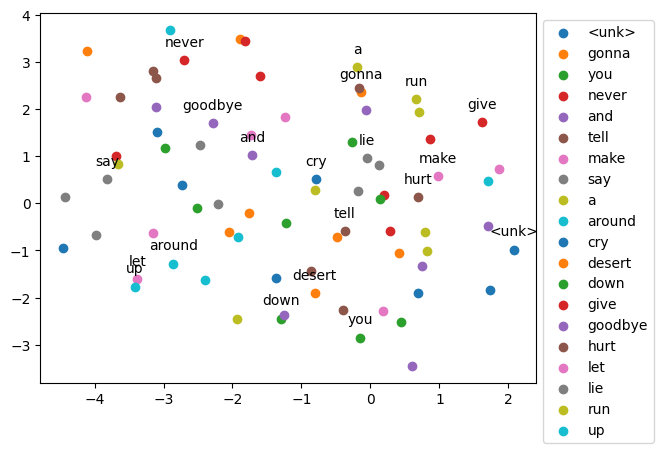

In [110]:
X = model_2.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [111]:
import numpy as np 

In [112]:
# repeat the process for context of four

CONTEXT_SIZE = 4
model_4 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_4.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss = train(dataloader, model_4, song)

save_path = '03_4gram.pth'
torch.save(model_4.state_dict(), save_path)

my_loss_list.append(my_loss)

 18%|█▊        | 18/100 [00:00<00:00, 173.46it/s]

Generated Song:


I just wanna tell you how Im feeling <unk>
Generated Song:


Never gonna tell a lie and hurt you never
Generated Song:


Never gonna let you down never
Generated Song:


Never gonna give you up never


 75%|███████▌  | 75/100 [00:00<00:00, 181.28it/s]

Generated Song:


Dont tell me youre too blind to see never
Generated Song:


Inside we both know whats been going on never
Generated Song:


I just wanna tell you how Im feeling never
Generated Song:


Inside we both know whats been going on never


100%|██████████| 100/100 [00:00<00:00, 178.88it/s]

Generated Song:


Never gonna make you cry never
Generated Song:


Never gonna run around and desert you never


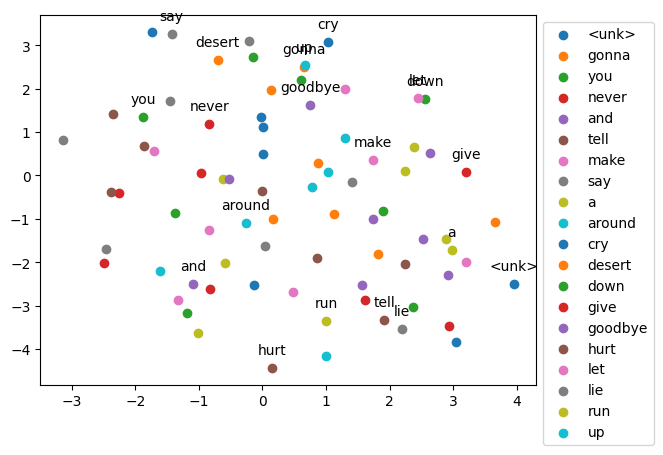

In [113]:
X = model_4.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Finally, an 8-context model

In [114]:
CONTEXT_SIZE=8
model_8 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_8.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss = train(dataloader, model_8, song)

save_path = '8gram.pth'

torch.save(model_8.state_dict(), save_path)

my_loss_list.append(my_loss)

 22%|██▏       | 22/100 [00:00<00:00, 213.22it/s]

Generated Song:


Never gonna give you up <unk>
Generated Song:


A full commitments what Im thinking of give
Generated Song:


Never gonna say goodbye give
Generated Song:


Gotta make you understand give
Generated Song:


Never gonna make you cry give


 90%|█████████ | 90/100 [00:00<00:00, 219.34it/s]

Generated Song:


Never gonna make you cry up
Generated Song:


Your hearts been aching but youre too shy to say it up
Generated Song:


Never gonna tell a lie and hurt you up
Generated Song:


Never gonna say goodbye up
Generated Song:


Inside we both know whats been going on up


100%|██████████| 100/100 [00:00<00:00, 217.44it/s]


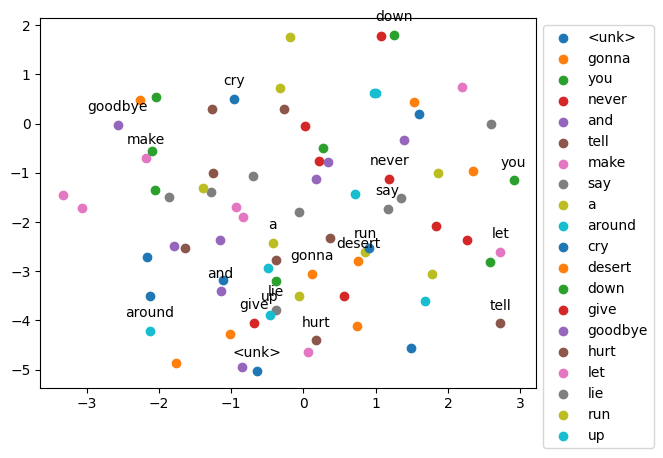

In [115]:
X = model_8.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


When considering the plotted loss for each model, a discernible trend emerges: an increase in context size correlates with a reduction in loss. While this specific approach lacks the inclusion of model validation or the utilization of conventional 
NLP evaluation metrics, the visual evidence substantiates its superior performance.


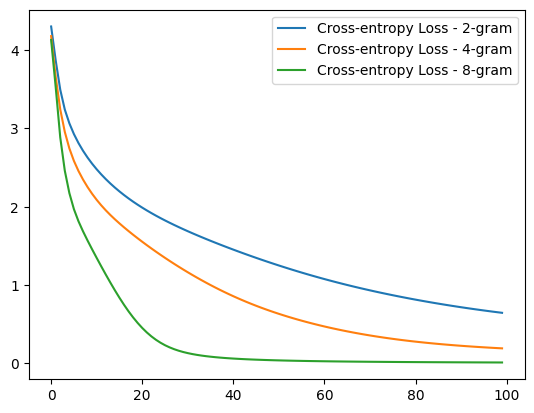

In [116]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    plt.plot(my_loss,label="Cross-entropy Loss - {}".format(model_name))
    plt.legend()

## Perplexity

Perplexity is a measurement used to evaluate the effectiveness of language models or probability models. It provides an indication of how well a model predicts a sample of data or the likelihood of an unseen event. Perplexity is commonly used in natural language processing tasks, such as machine translation, speech recognition, and language generation.

Perplexity is derived from the concept of cross-entropy loss, which measures the dissimilarity between predicted probabilities and actual probabilities. 

$$\text{Cross-Entropy Loss} = -\sum_{i=1}^{N} y_i \ln(p_i)$$
The cross-entropy loss is calculated by taking the negative sum of the products of the true labels $y_i$ and the logarithm of the predicted probabilities $p_i$ over $N$ classes.

Taking the exponential of the mean cross-entropy loss gives us the perplexity value.

$$\text{Perplexity} = e^{\frac{1}{N} \text{Cross-Entropy Loss}}$$


A lower perplexity value indicates that the model is more confident and accurate in predicting the data. Conversely, a higher perplexity suggests that the model is less certain and less accurate in its predictions.

Perplexity can be seen as an estimate of the average number of choices the model has for the next word or event in a sequence. A lower perplexity means that the model is more certain about the next word, while a higher perplexity means that there are more possible choices.


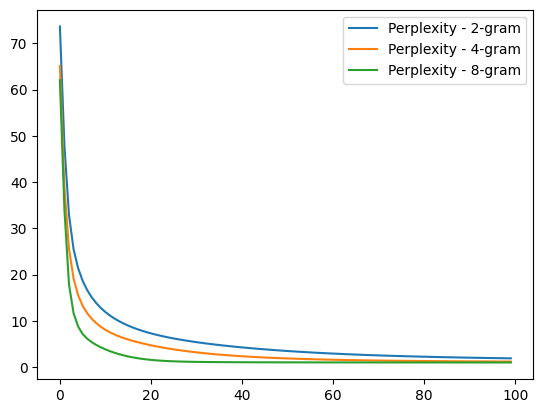

In [117]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    # Calculate perplexity using the loss
    perplexity = np.exp(my_loss)
    plt.plot(perplexity,label="Perplexity - {}".format(model_name))
    plt.legend()

## Exercises

In [118]:

nursery_rhymes = """
Little Miss Muffet
Sat on a tuffet,
Eating her curds and whey;
Along came a spider
Who sat down beside her
And frightened Miss Muffet away.

Twinkle, twinkle, little star,
How I wonder what you are!
Up above the world so high,
Like a diamond in the sky.

Baa, baa, black sheep,
Have you any wool?
Yes sir, yes sir,
Three bags full.

Jack and Jill went up the hill
To fetch a pail of water.
Jack fell down and broke his crown,
And Jill came tumbling after.

Hickory dickory dock,
The mouse ran up the clock.
The clock struck one,
The mouse ran down,
Hickory dickory dock.

Humpty Dumpty sat on a wall,
Humpty Dumpty had a great fall.
All the king's horses and all the king's men
Couldn't put Humpty together again.

Mary had a little lamb,
Its fleece was white as snow;
And everywhere that Mary went,
The lamb was sure to go.

Old MacDonald had a farm,
E-I-E-I-O,
And on his farm he had a cow,
E-I-E-I-O.

Itsy Bitsy Spider climbed up the waterspout.
Down came the rain and washed the spider out.
Out came the sun and dried up all the rain,
And the Itsy Bitsy Spider climbed up the spout again.

The wheels on the bus go round and round,
Round and round,
Round and round.
The wheels on the bus go round and round,
All through the town.

"""


### 2.- Preprocess the text data to tokenize and create n-grams

In [143]:
# Define the value of N for N-grams (context size)
N = 2  

# Preprocess the text (e.g., nursery rhymes) to tokenize and clean it
tokens = preprocess(nursery_rhymes)  # Use the preprocess function to tokenize the text

# Generate N-grams using the `genngrams` function
ngrams = genngrams(tokens)  

# Extract the first context-target pair from the list of N-grams
context, target = ngrams[0]  

### 3.- Convert context words into embeddings and pass them through a linear layer

In [144]:

# Tokenize text and create vocabulary
vocab = tokenizetext(nursery_rhymes)  


# Define embedding dimensions and create layers
embedding_dim = 20  # Each word will be represented as a 20-dimensional vector
linear = nn.Linear(embedding_dim * N, 128)  


# Generate embeddings using the custom embedding function
embeddings = genembedding(vocab)  


# Convert context words into embeddings
my_embeddings = embeddings(torch.tensor(vocab(context)))  


# Reshape embeddings to match the input shape required by the linear layer
my_embeddings = my_embeddings.reshape(1, -1)  

my_embeddings.shape

torch.Size([1, 40])

In [145]:

# Pass embeddings through the linear layer
output = linear(my_embeddings)  


# Print output shape for verification
print("Output shape:", output.shape)  

Output shape: torch.Size([1, 128])


### Exercise 4 -  Implement Batch Processing with Padding for Language Modeling.


In [147]:
# Define constants for training
CONTEXT_SIZE = 2  # The number of words in the context window
BATCH_SIZE = 10   # The number of samples per batch
EMBEDDING_DIM = 10  # The dimension of the word embeddings

# Compute padding to ensure the number of tokens is evenly divisible by the batch size
Padding = BATCH_SIZE - len(tokens) % BATCH_SIZE  


tokens_pad = tokens + tokens[0:Padding]  


# Define device (CPU/GPU) for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  


# Create DataLoader for batch processing
dataloader = DataLoader(
    tokens_pad, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)  


# Print length of total tokens after padding
print(f"Total tokens (after padding): {len(tokens_pad)}")


Total tokens (after padding): 240


### Exercise 5 - Train an N-gram language model using the provided code structure.


In [148]:
# Define context size for N-gram modeling
CONTEXT_SIZE = 2  # Number of previous words used as context for predicting the next word

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()  

# Initialize the N-gram language model
model3 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)  


# Define the optimizer (Stochastic Gradient Descent)
optimizer = optim.SGD(model3.parameters(), lr=0.01)  

# Implement Learning Rate Scheduling
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)  

# Train the model and track loss history
loss_history = train(dataloader, model3, nursery_rhymes)  


# Output expected behavior
print(f"Training started with {len(vocab)} words in vocabulary.")
print(f"Optimizer: {optimizer}")
print(f"Learning rate scheduler: {scheduler}")

 41%|████      | 41/100 [00:00<00:00, 208.83it/s]

Generated Song:


Round and round. bitsy
Generated Song:


Twinkle, twinkle, little star, the
Generated Song:


 the
Generated Song:


 the
Generated Song:


Couldn't put Humpty together again. ran


 91%|█████████ | 91/100 [00:00<00:00, 233.74it/s]

Generated Song:


Three bags full. little
Generated Song:


The clock struck one, little
Generated Song:


And on his farm he had a cow, little
Generated Song:


All the king's horses and all the king's men little
Generated Song:


 little


100%|██████████| 100/100 [00:00<00:00, 221.82it/s]

Training started with 127 words in vocabulary.
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Learning rate scheduler: <torch.optim.lr_scheduler.StepLR object at 0x3068ef3d0>


### Exercise 6 - After training, use the model to generate a new nursery rhyme and then print it.


In [149]:
# Select a random line from the nursery rhymes dataset
selected_line = pickrandomline(nursery_rhymes)  


# Generate a new rhyme using the trained language model
generated_rhyme = write_song(model3, selected_line)  


# Print the generated rhyme
print(generated_rhyme) 

Hickory dickory dock, little
